In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import pickle
import time
import json
import random
import os
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import tensorflow as tf
import SimpleITK as sitk

from glob import glob

from IPython import display
from nn_model import NNModel
from fake_model import FakeModel
from roi_queue import ROIQueue
from cube_queue import CubeQueue
from stat_helper import *

# mpld3.enable_notebook()

loaded_models = {}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def cycle_generator(image_filename, model_path, input_cube_size):
    model = NNModel(None, None, None, model_state_path=model_path)
    cube_q = CubeQueue(image_filename, model, input_cube_size=input_cube_size)
    image = cube_q.get_image()
    classes=['Emphysema', 'Normal', 'Bronchovascular', 'Honeycomb', 'Ground Glass (Reticular)', 'Ground Glass']
    with cube_q as gen:
        while True:
            [random_center, cube, result] = next(gen)
            slc = random_center[2]
            show_slice(
                image, 
                slc,
                roi=[random_center[0], random_center[1]],
                predictions=result[0], 
                classes=classes,
                title=image_filename + " ({0}-{1})".format(*random_center)
            )
            yield

In [5]:
def interactive_generator(image_filename, model_path, input_cube_size):
    model = NNModel(None, None, None, model_state_path=model_path)
    cube_q = CubeQueue(image_filename, model, input_cube_size=input_cube_size)
    image = cube_q.get_image()
    classes=['Emphysema', 'Normal', 'Bronchovascular', 'Honeycomb', 'Ground Glass (Reticular)', 'Ground Glass']
    with cube_q as gen:
        slider = None
        while True:
            [random_center, cube, result] = next(gen)
            slc = random_center[2]
            if slider is not None:
                slider.close()
            slider = show_slice_interactive(
                image, 
                slc,
                input_cube_size[2],
                roi=[random_center[0], random_center[1]],
                predictions=result[0], 
                classes=classes,
                title=image_filename + " ({0}-{1})".format(*random_center)
            )
            yield


In [6]:
def show_slice(img, slc, roi=None, lbl="Roi", predictions=None, classes=None, title=None, margin=0.05, dpi=80 ):
    
    nda = None
    spacing = None
    if type(img) is np.ndarray:
        nda = img
        spacing = [0.7, 0.7]
    else :
        nda = sitk.GetArrayFromImage(img)
        spacing = img.GetSpacing()
    
    ysize = nda.shape[1]
    xsize = nda.shape[2]
    
    display.clear_output(wait=True)

    z = slc

    extent = (0, xsize, ysize, 0)
    fig, ax_arr = plt.subplots(1, 2)
    fig.set_dpi(dpi)
    fig.set_size_inches( (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi)
    
    # Make the axis the right size...
    
    #ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])


    p_list = {}
    p_list[lbl] = patches.Rectangle(
        (roi[0], roi[1]),   # (x,y)
        15, # width
        15, # height
        fill=False,
        color='red',
        label=lbl
    )
    ax_arr[0].add_patch(p_list[lbl])
    ax_arr[0].imshow(nda[z,...], cmap="gray", extent=extent, interpolation=None)
    ax_arr[0].legend(handles=list(p_list.values()))
    

    y_pos = np.arange(len(classes))
    #ax_arr[1].set_yticks(y_pos)
    ax_arr[1].set_ylabel('Class')
    ax_arr[1].set_xlabel('Score')
    ax_arr[1].barh(y_pos, predictions, align='center')
    
    fig.tight_layout()
    
    def on_press(self, event):
        'on button press we will see if the mouse is over us and store some data'
        if event.inaxes != self.rect.axes: return

        contains, attrd = self.rect.contains(event)
        if not contains: return
        print('event contains', self.rect.xy)
        x0, y0 = self.rect.xy
        self.press = x0, y0, event.xdata, event.ydata
        
    cidpress = fig.canvas.mpl_connect('button_press_event', on_press)
        
    # plugins.connect(fig, plugins.MousePosition(fontsize=14))

    # mpld3.display(fig)
    
    plt.show()
    

In [13]:
def show_slice_interactive(img, slc, slc_count, roi=None, lbl="Roi", predictions=None, classes=None, title=None, margin=0.05, dpi=80 ):
    
    nda = None
    spacing = None
    if type(img) is np.ndarray:
        nda = img
        spacing = [0.7, 0.7]
    else :
        nda = sitk.GetArrayFromImage(img)
        spacing = img.GetSpacing()
    
    ysize = nda.shape[1]
    xsize = nda.shape[2]
    
    def callback(slc):
        
        display.clear_output(wait=True)

        z = slc['new']
        extent = (0, xsize, ysize, 0)
        fig, ax_arr = plt.subplots(1, 2)
        fig.set_dpi(dpi)
        fig.set_size_inches(2 * (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi)

        # Make the axis the right size...

        #ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])


        p_list = {}
        p_list[lbl] = patches.Rectangle(
            (roi[0], roi[1]),   # (x,y)
            15, # width
            15, # height
            fill=False,
            color='red',
            label=lbl
        )
        ax_arr[0].add_patch(p_list[lbl])
        ax_arr[0].imshow(nda[z,...], cmap="gray", extent=extent, interpolation=None)
        ax_arr[0].legend(handles=list(p_list.values()))


        y_pos = np.arange(len(classes))
        #ax_arr[1].set_yticks(y_pos)
        ax_arr[1].set_ylabel('Class')
        ax_arr[1].set_xlabel('Score')
        ax_arr[1].barh(y_pos, predictions, align='center', tick_label=classes)

        fig.tight_layout()
        if title:
            plt.title(title)

        plt.show()
    
    slider = widgets.IntSlider(
        value=int(slc),
        min=slc-int(slc_count/2),
        max=slc+int(slc_count/2)
    )
    slider.observe(callback, names=['value'])
    display.display(slider)
    return slider
    

In [67]:
def show_slice_correct(img, slc, slc_count, correct_answer=None, roi=None, lbl="Roi", predictions=None, classes=None, title=None, margin=0.05, dpi=80 ):
    
    nda = None
    spacing = None
    if type(img) is np.ndarray:
        nda = img
        spacing = [0.7, 0.7]
    else :
        nda = sitk.GetArrayFromImage(img)
        spacing = img.GetSpacing()
    
    ysize = nda.shape[1]
    xsize = nda.shape[2]
    
    def callback(slc):
        
        display.clear_output(wait=True)

        z = slc['new']
        extent = (0, xsize, ysize, 0)
        fig, ax_arr = plt.subplots(1, 2)
        fig.set_dpi(dpi)
        fig.set_size_inches(2 * (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi)

        # Make the axis the right size...

        #ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])


        p_list = {}
        p_list[lbl] = patches.Rectangle(
            (roi[0], roi[1]),   # (x,y)
            15, # width
            15, # height
            fill=False,
            color='red',
            label=lbl
        )
        ax_arr[0].add_patch(p_list[lbl])
        ax_arr[0].imshow(nda[z,...], cmap="gray", extent=extent, interpolation=None)
        ax_arr[0].legend(handles=list(p_list.values()))


        y_pos = np.arange(len(classes))
        #ax_arr[1].set_yticks(y_pos)
        ax_arr[1].set_ylabel('Class')
        ax_arr[1].set_xlabel('Score')
        ax_arr[1].barh(y_pos, predictions, align='center', tick_label=classes)

        fig.tight_layout()
        if title:
            plt.title(title)

        plt.show()
        print(correct_answer)
    
    slider = widgets.IntSlider(
        value=int(slc),
        min=slc-int(slc_count/2),
        max=slc+int(slc_count/2)
    )
    slider.observe(callback, names=['value'])
    display.display(slider)
    return slider
    

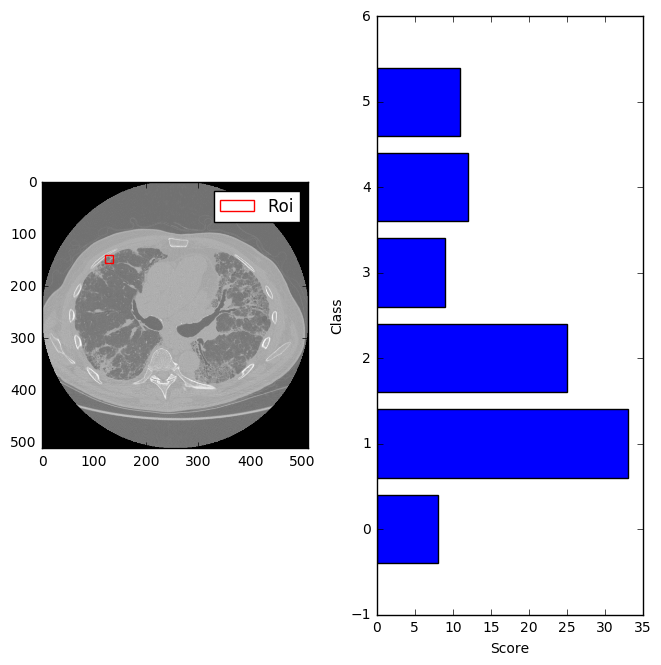

In [7]:
model_path = '/home/mostafa/spiromics/Github/Code/models/convnet_[3072000, 94]_20161026-072854'

image_list = list(glob('./RawData/*.img.gz'))
# image_list = list(glob('/home/mostafa/spiromics/Github/Code/RawData/non-labelled/1/*.nrrd'))
random.shuffle(image_list)


image_filename = None
for im_path in image_list:
    image_filename = im_path

# model = NNModel(None, None, None, model_state_path=model_path)
model = FakeModel(6)
model.test({'image': np.array([1,2,3,4])})


cube_q = CubeQueue(image_filename, model, input_cube_size=[15, 15, 5])

image = cube_q.get_image()
classes=['Emphysema', 'Normal', 'Bronchovascular', 'Honeycomb', 'Ground Glass (Reticular)', 'Ground Glass']
      
counter = 0
try:
    while counter < 500:
        next(gen)
        time.sleep(5)
except KeyboardInterrupt:
    print("Slideshow terminated")

    

In [ ]:
model_path = '/home/mostafa/spiromics/Github/Code/models/convnet_[3072000, 94]_20161026-072854'

image_list = list(glob('/home/mostafa/spiromics/Github/Code/RawData/*.img.gz'))
image_list = list(glob('/home/mostafa/spiromics/Github/Code/RawData/non-labelled/1/*.nrrd'))
random.shuffle(image_list)

image_filename = None
for im_path in image_list:
    image_filename = im_path

model = NNModel(None, None, None, model_state_path=model_path)
cube_q = CubeQueue(image_filename, model)

image = cube_q.get_image()
classes=['Emphysema', 'Normal', 'Bronchovascular', 'Honeycomb', 'Ground Glass (Reticular)', 'Ground Glass']
      
counter = 0
try:
    with cube_q as gen:
        while counter < 11500:
            counter += 1
            [random_center, cube, result] = next(gen)
            slc = random_center[2]
            show_slice(
                image, 
                slc, 
                roi=[random_center[0], random_center[1]],
                predictions=result[0], 
                classes=classes,
                title="{0}-{1}".format(*random_center)
            )
            time.sleep(3)
except KeyboardInterrupt:
    print("Slideshow terminated")
        

In [ ]:
image_list = list(glob('/home/mostafa/spiromics/Github/Code/RawData/non-labelled/1/*.nrrd'))

image = None
for im_path in image_list:
    image = sitk.ReadImage(im_path)
    print(image.GetSize(), image.GetSpacing())
    break

In [ ]:
ndarray = np.float32(np.swapaxes(sitk.GetArrayFromImage(image), 0, 2))
ndarray -= np.mean(ndarray, axis=0)
ndarray /= np.std(ndarray, axis=0)

cube_size = [15, 15 ,23]
image_size = list(ndarray.shape)
x_range = [
    [int(image_size[0] * .15) + cube_size[0], int(image_size[0] * .45) - cube_size[0]],
    [int(image_size[0] * .55) + cube_size[0], int(image_size[0] * .80) - cube_size[0]]
]
y_range = [int(image_size[1] * .25) + cube_size[1], int(image_size[1] * .75) - cube_size[1]]
z_range = [int(image_size[2] * .3) - cube_size[2], int(image_size[2] * .6) + cube_size[2]]

random_center = [
    random.randint(*x_range[random.randint(0, 1)]),
    random.randint(*y_range),
    random.randint(*z_range)
]
cube = ndarray[
    random_center[0]-cube_size[0] :  random_center[0]+cube_size[0],
    random_center[1]-cube_size[1] :  random_center[1]+cube_size[1],
    random_center[2]-cube_size[2] :  random_center[2]+cube_size[2],
]
print(cube)

In [ ]:
def build_ui():
    
    input_select_pool = widgets.SelectMultiple(
        description='Available Models:',
        options=list(os.listdir('./models/')),
    )


    def on_button_clicked(btn):
        selected_models = list(input_select_pool.value)
        selected_models = [
            'convnet_[1600000, 93]_20161024-145242',
            'convnet_[1600000, 93]_20161024-145241'
        ]
        for m in selected_models:
            model_path = "{0}{1}".format('./models/', m)
            model_info = pickle.load(open(model_path + '/model.p', 'rb'))
            print(model_info)
            
        
              

    btn_load = widgets.Button(description="Load Models")
    
    btn_load.on_click(on_button_clicked)
    display.display(input_select_pool)
    display.display(btn_load)
    on_button_clicked(None)
    
    
build_ui()

In [ ]:
container = widgets.Box

In [ ]:
comps = ['A', 'B', 'C']
trigs = ['X', 'Y', 'Z']

components = []
for comp in comps:
    components.append(widgets.CheckboxWidget(description = comp, value=False))

comp_container = widgets.ContainerWidget(children = components)
comp_container.add_class('vbox')
comp_container.add_class("align-start")

triggers = []
for trig in trigs:
    triggers.append(widgets.CheckboxWidget(description = trig, value=False))

trig_container = widgets.ContainerWidget(children = triggers)
trig_container.add_class('vbox')
trig_container.add_class("align-end")

main_container = widgets.ContainerWidget(children = [comp_container, trig_container])
main_container.set_css({
    'background': '#999999',
    'width': '100%',
})
main_container.remove_class('vbox')
main_container.add_class("hbox")

In [11]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report

def print_confusion_matrix(plabels, tlabels):
    """
        functions print the confusion matrix for the different classes
        to find the error...

        Input:
        -----------
        plabels: predicted labels for the classes...
        tlabels: true labels for the classes

        code from: http://stackoverflow.com/questions/2148543/how-to-write-a-confusion-matrix-in-python
    """
    plabels = pd.Series(plabels)
    tlabels = pd.Series(tlabels)

    # draw a cross tabulation...
    df_confusion = pd.crosstab(tlabels,plabels, rownames=['Actual'], colnames=['Predicted'], margins=True)

    #print df_confusion
    return df_confusion

def confusionMatrix(text,Labels,y_pred, not_partial):
    y_actu = np.where(Labels[:]==1)[1]
    df = print_confusion_matrix(y_pred,y_actu)
    print("\n",df)
    #print plt.imshow(df.as_matrix())
    if not_partial:
        print("\n",classification_report(y_actu, y_pred))
    print("\n\t------------------------------------------------------\n")

def do_eval(message, sess, correct_prediction, accuracy, pred, X_, y_,x,y):
    predictions = sess.run([correct_prediction], feed_dict={x: X_, y: y_})
    prediction  = tf.argmax(pred,1)
    labels = prediction.eval(feed_dict={x: X_, y: y_}, session=sess)
    print(message, accuracy.eval({x: X_, y: y_}),"\n")
    confusionMatrix("Partial Confusion matrix",y_,predictions[0], False)#Partial confusion Matrix
    confusionMatrix("Complete Confusion matrix",y_,labels, True) #complete confusion Matrix

In [10]:
def evaluation(logits, labels):
    s = tf.Session()
    print(labels)
    is_label_one = tf.cast(labels, dtype=tf.bool)
    is_label_zero = tf.logical_not(is_label_one)

    correct_prediction = tf.nn.in_top_k(logits, labels, 1, name="correct_answers")
    false_prediction = tf.logical_not(correct_prediction)
    
    print(s.run([correct_prediction, false_prediction]))
    true_positives = tf.reduce_sum(tf.to_int32(tf.logical_and(correct_prediction,is_label_one)))
    false_positives = tf.reduce_sum(tf.to_int32(tf.logical_and(false_prediction, is_label_zero)))
    true_negatives = tf.reduce_sum(tf.to_int32(tf.logical_and(correct_prediction, is_label_zero)))
    false_negatives = tf.reduce_sum(tf.to_int32(tf.logical_and(false_prediction, is_label_one)))
    return true_positives, false_positives, true_negatives, false_negatives

correct = [
    [0, 0, 1],
    [0, 1, 0],
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
]
correct = [0, 1, 2, 3, 4, 3, 2, 1, 0]
predict = [    
    [1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 0, 1, 0],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 1, 0],
    [0, 0, 1, 0, 0],
    [0, 1, 0, 0, 0],
    [1, 0, 0, 0, 0]
]
# Now you can do something like this in your session:
with tf.Session() as sess:
    true_positives, \
    false_positives, \
    true_negatives, \
    false_negatives = sess.run(evaluation(predict, correct))

    # you can print the confusion matrix using the 4 values from above, or get precision and recall:
    precision = float(true_positives) / float(true_positives+false_positives)
    recall = float(true_positives) / float(true_positives+false_negatives)

    # or F1 score:
    F1_score = 2 * ( precision * recall ) / ( precision+recall )
    
    
    #print(true_positives,
    #false_positives,
    #true_negatives,
    #false_negatives)
    #print(precision)
    #print(recall)
    #print(F1_score)

[0, 1, 2, 3, 4, 3, 2, 1, 0]
[array([ True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool), array([False, False, False, False, False, False, False, False, False], dtype=bool)]


In [ ]:
def run_graph(dataset_filename,
        network_structure_json,
        angles=None,
        iterations=8e6,
        batch_size=32,
        drop_out=0.5,
        reg_power=5e-4,
        learning_rate=1e-5):
    
    
    if angles is None:
        angles = {
            'train': None,
            'validate': None,
            'test': None
        }
    
    roi_queue = ROIQueue(
        dataset_filename, 
        batch_size=batch_size, 
        train_angles=angles['train'],
        validate_angles=angles['validate'],
        test_angles=angles['test']
    )
    roi_queue.start()
    
    stat_train_acc = []
    stat_test_acc = []
    stat_data_loss = []
    stat_learning_rate = []
    
    sm_stat_train_acc = []
    sm_stat_test_acc = []
    sm_stat_data_loss = []
    
    X_train, Y_train = roi_queue.get_next_batch('train', 1, flattened=False)
    
    full_input_shape = {}
    input_shape = {}
    for subset_id in X_train:
        full_input_shape[subset_id] = []
        input_shape[subset_id] = []
        for idx, i in enumerate(X_train[subset_id].shape):
            if idx == 0:
                full_input_shape[subset_id].append(None)
                continue
            full_input_shape[subset_id].append(i)
            input_shape[subset_id].append(i)

        if len(full_input_shape[subset_id]) > 2:
            input_shape[subset_id].append(1)
            full_input_shape[subset_id].append(1)
    
    num_classes = Y_train.shape[1]
    network_config = json.loads(network_structure_json)
    builder = NetCalc(input_shape, num_classes, batch_size)


    
    pred = builder.build_from_config(network_config)
    sess = tf.Session()
    saver = tf.train.Saver()
    
    x = builder.get_X()
    y = tf.placeholder(tf.float32, [None, num_classes], name="y")    
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
    cost += reg_power * builder.get_reg()

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    
    # Evaluate model
    correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        tf.scalar_summary('accuracy', accuracy)

    # Initializing the variables
    merged = tf.merge_all_summaries()

    init = tf.initialize_all_variables()
    sess.run(init)
  
    model_meta_information = {
        "type": "convnet",
        "arch": network_config,
        "date": time.time(),
        "iterations_req": iterations,
        "time_start": time.time(),
        "time_end" : 0,
        "iterations_done": 0,
        "regularization_strength": reg_power,
        "drop_out_probability": drop_out,
        "batch_size": batch_size,
        "initial_learning_rate": 1e-5,
        "stats" : {
            "train_accurecy": None,
            "test_accurecy": None,
            "train_loss": None
        },
        "result": None
    }
    directory_format = "{0}/convnet_{1}_{2}/"
    filename_format = "model.{0}"

    stat_step = 20
    display_step = 20
    train_loss = 0
    step = 1
    with sess:
        try:
            # Keyep training until reach max iterations
            while step * batch_size < iterations:
                batch_x, batch_y = roi_queue.get_next_batch('train', batch_size, flattened=False)
                train_dict = {
                    y: batch_y
                }
                for idx in batch_x:
                    full_input_shape[idx][0] = batch_size
                    batch_x[idx].shape = full_input_shape[idx]
                    train_dict[x[idx]] = batch_x[idx]
                
                # Run optimization op (backprop)
                summary, _ = sess.run([merged, optimizer], feed_dict=train_dict)
                
                if step % stat_step == 0:
                    test_batch_x, test_batch_y = roi_queue.get_next_batch('test', 32, flattened=False)
                    test_dict = {
                        y: batch_y
                    }
                    for idx in batch_x:
                        full_input_shape[idx][0] = 32
                        test_batch_x[idx].shape = full_input_shape[idx]
                        test_dict[x[idx]] = test_batch_x[idx]

                    train_acc, train_loss = sess.run([accuracy, cost], feed_dict=train_dict)
                    summary, test_acc = sess.run([merged, accuracy], feed_dict=test_dict)
                    stat_data_loss.append([step * batch_size, train_loss])
                    stat_train_acc.append([step * batch_size, train_acc])
                    stat_test_acc.append([step * batch_size, test_acc])
                    stat_learning_rate.append([step * batch_size, learning_rate])
                    
                
                if step % display_step == 0:
                    
                    steps_count = int(display_step / stat_step)
                    tr_acc = int(get_mean(stat_train_acc, steps=steps_count) * 100)
                    ts_acc = int(get_mean(stat_test_acc, steps=steps_count) * 100)
                    sm_stat_train_acc.append([step * batch_size, tr_acc])
                    sm_stat_test_acc.append([step * batch_size, ts_acc])
                    
                    progress = get_mean_diff(stat_train_acc, steps_count)
                    
                    update_graph(stat_data_loss, sm_stat_train_acc, sm_stat_test_acc, stat_learning_rate)

                    prg = 0 if progress is None else progress
                    print("Iter " + str(step * batch_size) +
                          ", Loss = {:.6f}".format(train_loss) +
                          ", Training Accuracy = {:.3f}".format(tr_acc) +
                          ", Test Accuracy = {:.3f}".format(ts_acc)
                      )

                model_meta_information["stats"]["train_accurecy"] = sm_stat_train_acc
                model_meta_information["stats"]["test_accurecy"] = sm_stat_test_acc
                model_meta_information["stats"]["test_accurecy"] = stat_data_loss
                model_meta_information["result"] = None if len(sm_stat_test_acc) == 0 else sm_stat_test_acc[-1]
                model_meta_information["time_end"] = time.time()
                model_meta_information["iterations_done"] = (step * batch_size)
                step += 1

            if len(sm_stat_test_acc) != 0:
                timestr = time.strftime("%Y%m%d-%H%M%S")
                test_batch_x, test_batch_y = roi_queue.get_next_batch('test', 32, flattened=False)
                directory_name = directory_format.format('./models/', sm_stat_test_acc[-1], timestr)
                meta_filename = directory_name + filename_format.format("p")
                ckpt_filename = directory_name + filename_format.format("ckpt")
                test_X_filename = directory_name + "test_data_X.npy"
                test_Y_filename = directory_name + "test_data_Y.npy"
                os.makedirs(directory_name, mode=0o777, exist_ok=True)
                np.save(test_X_filename, test_batch_x)
                np.save(test_Y_filename, test_batch_y)
                saver.save(sess, ckpt_filename)
                pickle.dump(model_meta_information, open(meta_filename, "wb"))
            roi_queue.stop()
            
            print("Optimization Finished!")
        except KeyboardInterrupt:
            
            if len(sm_stat_test_acc) != 0:
                model_meta_information["time_end"] = time.time()
                model_meta_information["iterations_done"] = (step * batch_size)
                timestr = time.strftime("%Y%m%d-%H%M%S")
                test_batch_x, test_batch_y = roi_queue.get_next_batch('test', 32, flattened=False)
                directory_name = directory_format.format('./models/', sm_stat_test_acc[-1], timestr)
                meta_filename = directory_name + filename_format.format("p")
                ckpt_filename = directory_name + filename_format.format("ckpt")
                test_X_filename = directory_name + "test_data_X.npy"
                test_Y_filename = directory_name + "test_data_Y.npy"
                os.makedirs(directory_name, mode=0o777, exist_ok=True)
                np.save(test_X_filename, test_batch_x)
                np.save(test_Y_filename, test_batch_y)
                saver.save(sess, ckpt_filename)
                pickle.dump(model_meta_information, open(meta_filename, "wb"))
            
            roi_queue.stop()
            
            print("Optimization Terminated!")

In [ ]:
def build_image_ui():
    
    def on_image_selected(btn):
        print(input_select_pool.value)

    input_select_pool = widgets.Dropdown(
        description='Available Images:',
        options=list(os.listdir('/media/mostafa/Windows/SummerProjectData/Data/original_data/raw/4/')),
    )
    input_select_pool.observe(on_image_selected)

run_graph('exported_rois.p', network, iterations=1e7, batch_size=32)

In [ ]:
network = """[{
    "id": "data",
    "arch": [{
		"type": "fc",
		"count": 16
	}]
},{
    "id": "image",
    "arch":[{
		"type": "conv",
		"filter_size": 5,
		"filter_count": 20,
		"stride": 1,
		"maintain_spatial": false
	},{
		"type": "conv",
		"filter_size": 5,
		"filter_count": 50,
		"stride": 1,
		"maintain_spatial": false
	}]
}, {
    "id": "out",
    "arch": [{
		"type": "fc",
		"count": 1024
	}]
}]
"""

run_graph('exported_rois.p', network, iterations=1e7, batch_size=32)

In [ ]:
model = NNModel(None, None, None, model_state_path='/home/mostafa/spiromics/Github/Code/models/convnet_[3072000, 94]_20161026-072854')

In [ ]:
roi_queue = ROIQueue('exported_rois.p', batch_size=32)
roi_queue.start()

In [ ]:
while(True):
    X, Y = roi_queue.get_next_batch('train', 128, flattened=False)
    prediction = model.test(X)
    print(prediction)
    break
    correct = Y
    correct.shape = (-1,)
    #print(prediction)
    #print(np.argmax(prediction), np.argmax(correct))
    #time.sleep(0.5)